In [1]:
#evaluation of miniProt result using the poaceae consensus query
#author: Sheng-Kai Hsu
#created: 2024.08.05
#last edited: 2024.08/05
rm(list=ls())

In [2]:
library(rtracklayer)
library(Biostrings)
library(limma)
library(scales)
library(LSD)
library(parallel)
library(tidyverse)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: XVector


Attaching package: ‘Biostrings’


The f

In [3]:
queryFa = readAAStringSet("/workdir/sh2246/p_phyloGWAS/output/poaceaeHelixerOG_ancSeq_gapRemoved_filtered.fa")
queryFa_length=width(queryFa)
names(queryFa_length)=names(queryFa)


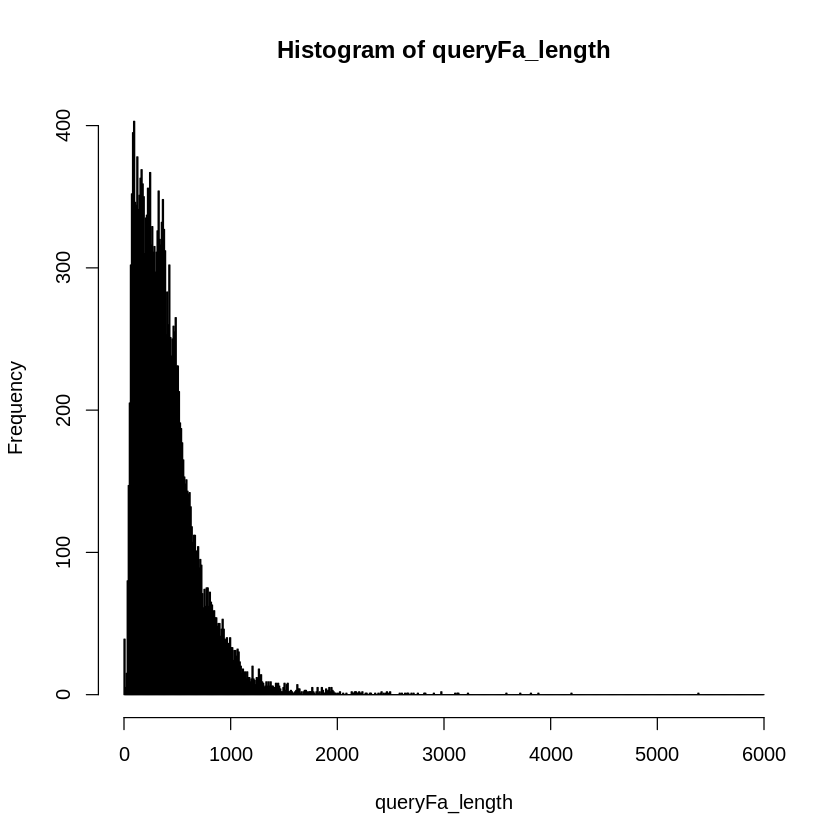

In [5]:
hist(queryFa_length,breaks= seq(0,6000,10))

In [15]:
calculate_range <- function(start, end) {
  intervals <- data.frame(Start = start, End = end)
  intervals <- intervals[order(intervals$Start), ]
  
  # Merge overlapping intervals
  merged_intervals <- Reduce(function(acc, current) {
    if (is.null(acc)) {
      return(current)
    }
    last <- acc[nrow(acc), ]
    if (last$End >= current$Start) {
      acc[nrow(acc), 'End'] <- max(last$End, current$End)
    } else {
      acc <- rbind(acc, current)
    }
    acc
  }, split(intervals, 1:nrow(intervals)), init = NULL)
  
  # Calculate total range
  total_range <- sum(merged_intervals$End - merged_intervals$Start)
  return(total_range)
}


In [16]:
eval_scaffold = function(j){
    gff_original = readGFF(paste0("/workdir/sh2246/p_phyloGWAS/output/orthofinderMiniProt/",j,".gff"))

    if(nrow(gff_original)>0) {
        gff.mrna_original = gff_original[gff_original[,3]=="mRNA",]

        queryStat_original = strsplit2(gff.mrna_original$Target," ")
        queryStat_original = as.data.frame(queryStat_original)
        colnames(queryStat_original) = c("query","start","end")
        queryStat_original$range = as.numeric(queryStat_original[,3])-as.numeric(queryStat_original[,2])+1

        qcov_original=c()
        for (i in unique(queryStat_original[,1])){
          qcov_original=c(qcov_original,queryStat_original[queryStat_original[,1]==i,4]/queryFa_length[i])
        }
        queryStat_original$coverage = qcov_original

        queryStat_original[,2] = as.numeric(queryStat_original[,2])
        queryStat_original[,3] = as.numeric(queryStat_original[,3])

        queryLengthCov_original <- queryStat_original %>% group_by(query) %>% 
        summarise(TotalRange = calculate_range(start, end))
        queryLengthCov_original = as.data.frame(queryLengthCov_original)
        rownames(queryLengthCov_original)=queryLengthCov_original[,1]

        out = queryFa_length[queryLengthCov_original[,1]]-queryLengthCov_original[,2]
        names(out) = queryLengthCov_original[,1]
        return(out)
    }
    else return(NULL)
}


In [13]:
sampleID = gsub(".gff","",list.files("/workdir/sh2246/p_phyloGWAS/output/orthofinderMiniProt/"))
missBP = simplify2array(mclapply(sampleID,eval_scaffold,mc.cores = 10))

Warning message in mclapply(sampleID, eval_scaffold, mc.cores = 10):
“all scheduled cores encountered errors in user code”


In [74]:
missBP[[which(sampleID%in%'ASM1935983v1')]]['OG0026028']

OG0026028 
        1

In [20]:
names(missBP) = sampleID
missBP_noMissing = simplify2array(missBP[!sapply(missBP,length)==0])
missBP_noMissing = sapply(missBP_noMissing,function(x) x[names(queryFa_length)])
rownames(missBP_noMissing) = names(queryFa_length)
missBP_naFilled = apply(missBP_noMissing,2,function(x) {
    x[is.na(x)] = queryFa_length[is.na(x)]
    return(x)
})

In [21]:
missBP_cat = apply(missBP_naFilled,2,function(x) table(as.numeric(cut(x,c(-10,0,30,90,300,6e3))))[as.character(1:5)])
missBP_cat[is.na(missBP_cat)]=0

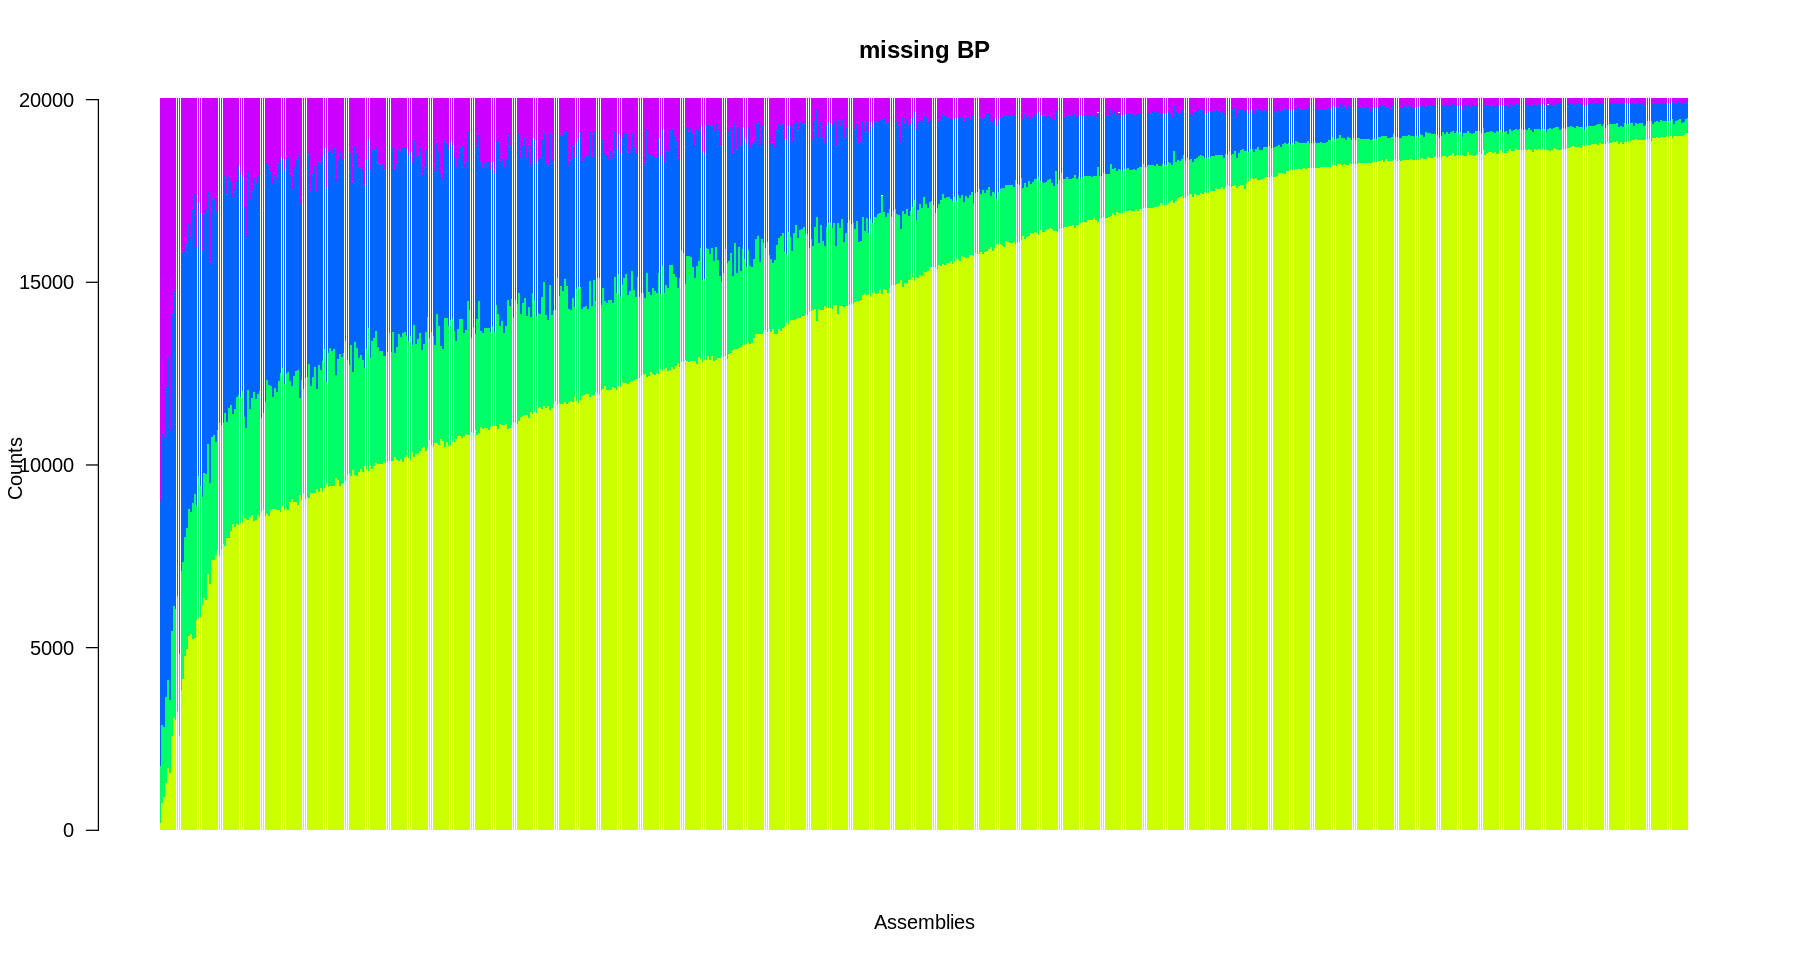

In [28]:
options(repr.plot.width = 15,repr.plot.height = 8)
barplot(missBP_cat[,order(cov_cat[1,])],col =rainbow(5),border = NA,las = 2,xaxt='n',
        xlab = "Assemblies",ylab = "Counts",main = "missing BP")

In [24]:
cov_cat = apply(missBP_naFilled,2,function(x) table(12-as.numeric(cut(1-x/queryFa_length,seq(-0.1,1,0.1))))[as.character(1:11)])

In [25]:
cov_cat[is.na(cov_cat)] = 0

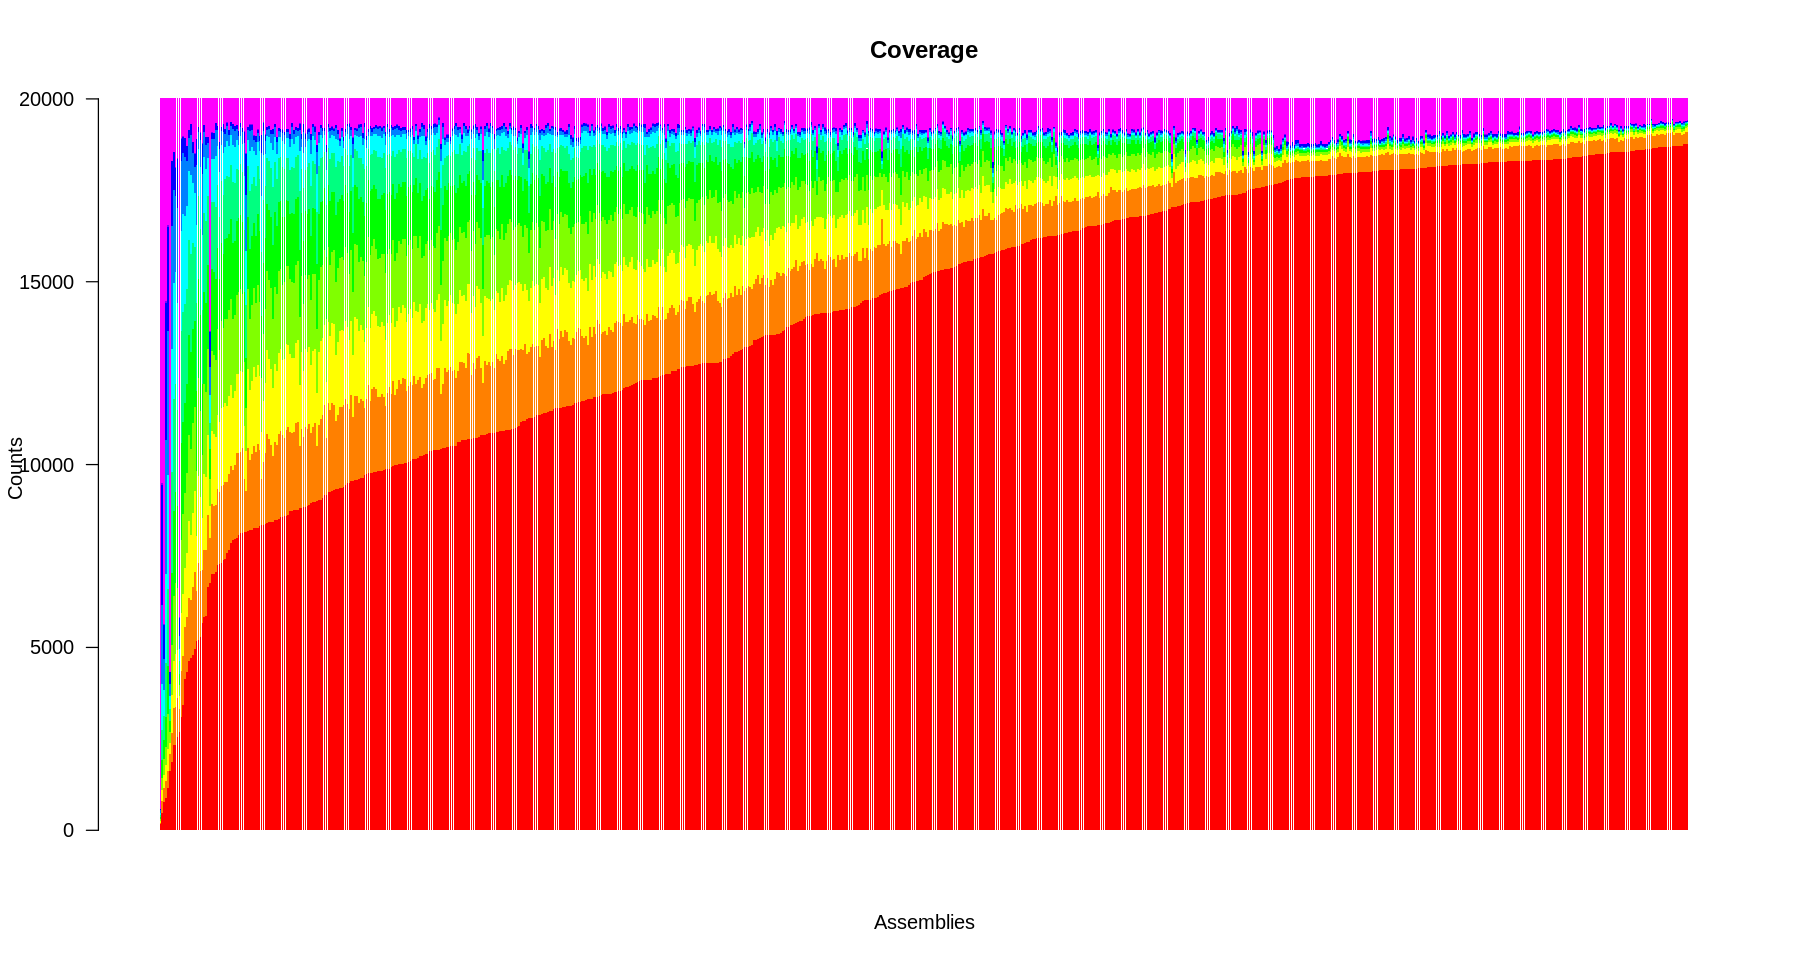

In [29]:
barplot(cov_cat[,order(cov_cat[1,])],col = rainbow(12)[1:11],border =NA,las = 2,xaxt='n',
        xlab = "Assemblies",ylab = "Counts",main = "Coverage")

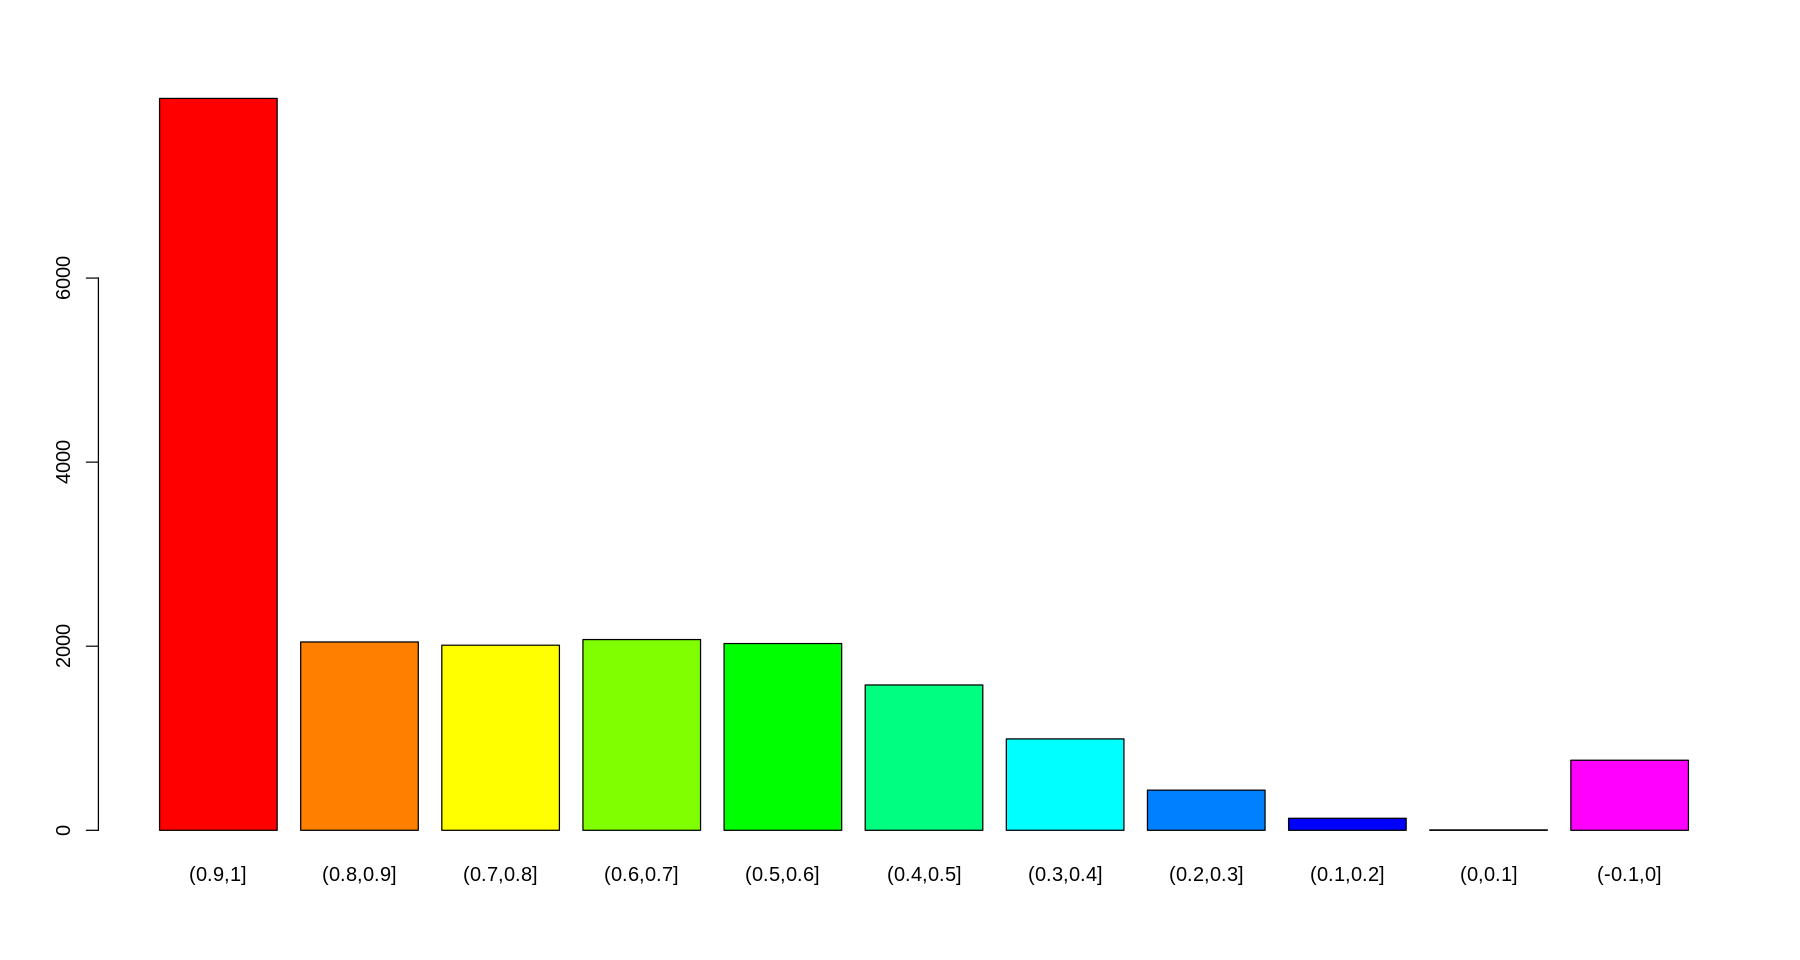

In [33]:
barplot(rev(table(cut(1-missBP_naFilled[,5]/queryFa_length,seq(-0.1,1,0.1)))),col =rainbow(12)[1:11] )

In [34]:
eval_contig = function(j){
    gff_original = readGFF(paste0("/workdir/sh2246/p_phyloGWAS/output/orthofinderMiniProt/",j,".gff"))

    if(nrow(gff_original)>0) {
        gff.mrna_original = gff_original[gff_original[,3]=="mRNA",]

        queryStat_original = strsplit2(gff.mrna_original$Target," ")
        queryStat_original = as.data.frame(queryStat_original)
        colnames(queryStat_original) = c("query","start","end")
        queryStat_original$range = as.numeric(queryStat_original[,3])-as.numeric(queryStat_original[,2])+1

        out = table(queryStat_original[,1])[names(queryFa_length)]
        names(out) = names(queryFa_length)
        return(out)
    }
    else return(NULL)
}


In [ ]:
numContig = simplify2array(mclapply(sampleID,eval_contig,mc.cores = 10))
# numContig_noMissing = simplify2array(numContig[!sapply(numContig,length)==0])

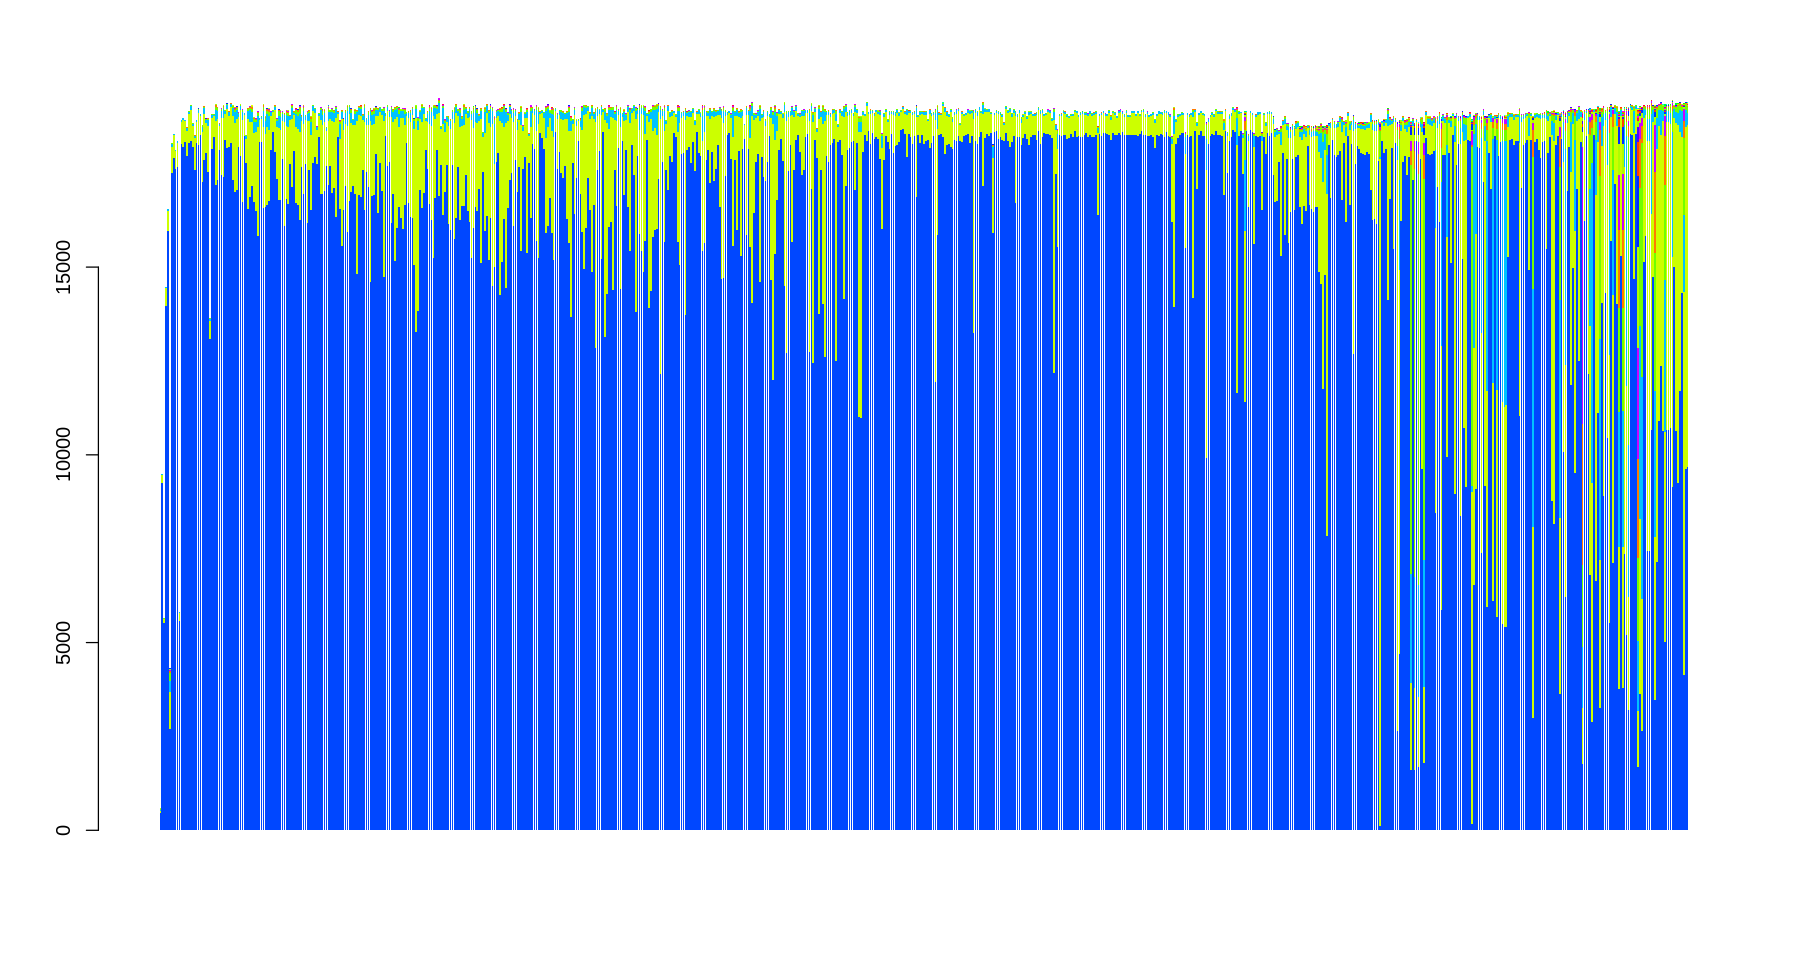

In [43]:
numContig_freq = apply(numContig,2,function(x) table(x)[as.character(1:31)])
numContig_freq[is.na(numContig_freq)] = 0
set.seed(666)
mybpcol = rainbow(50)[sample(1:50,31)]
barplot(numContig_freq[,order(cov_cat[1,])],col = mybpcol,border = NA)

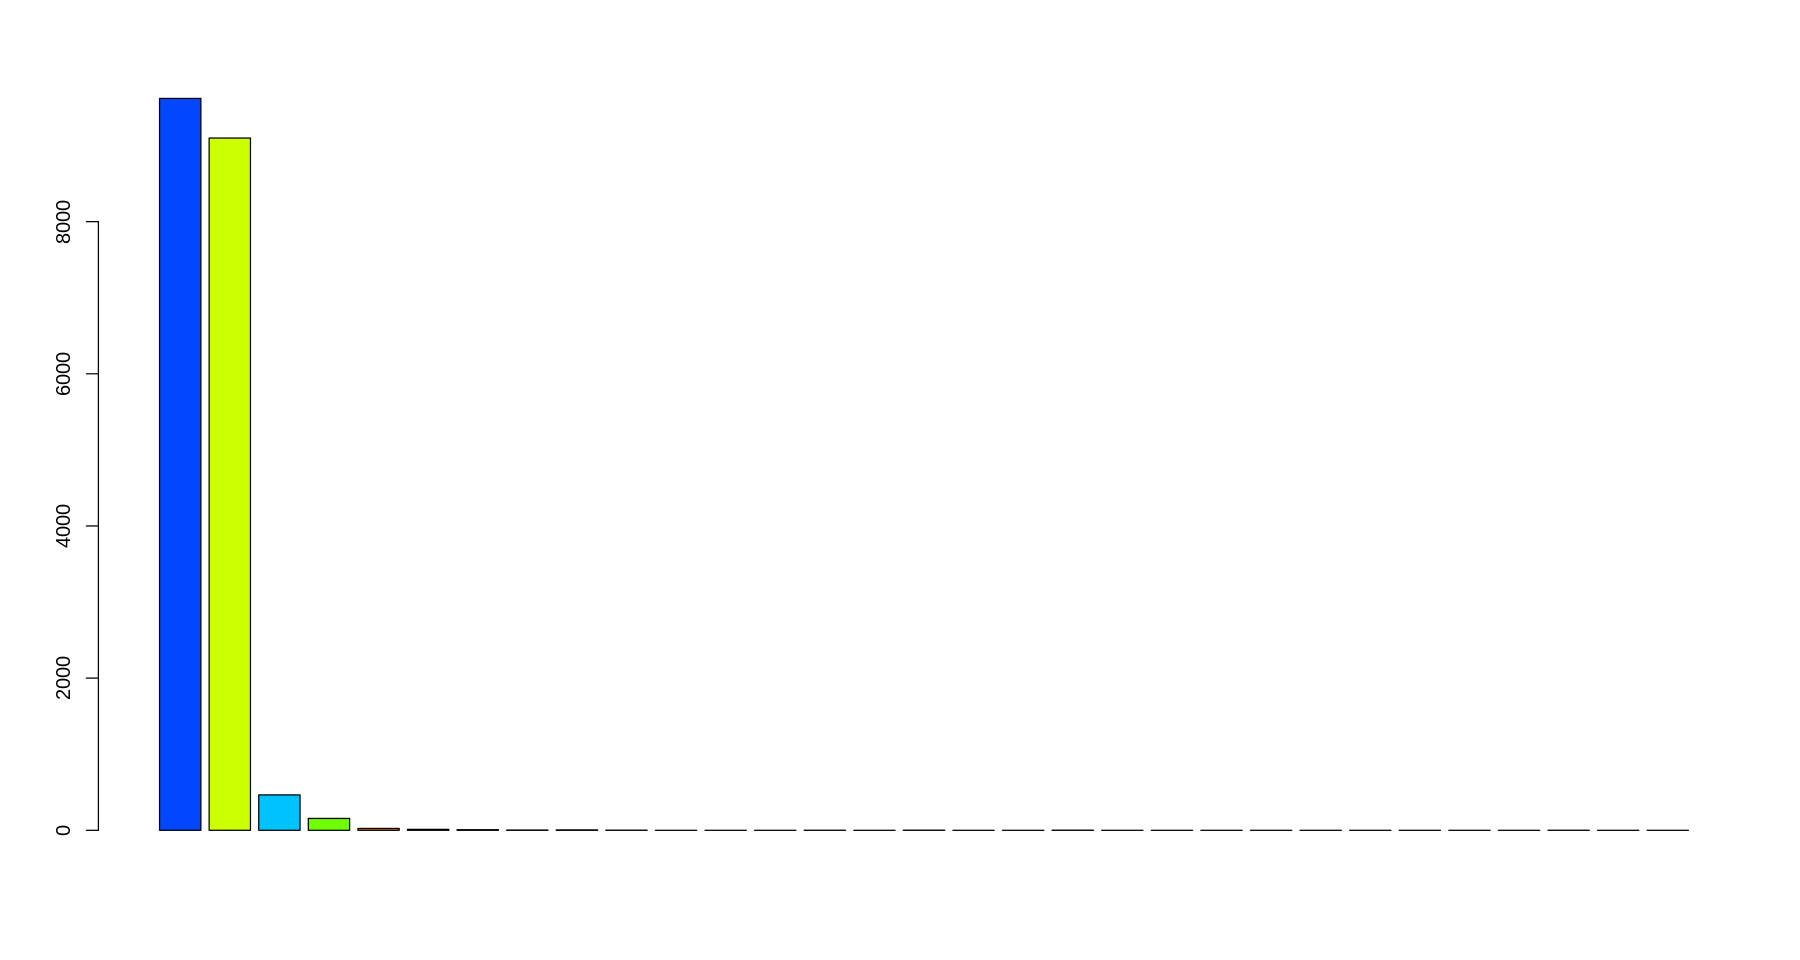

In [49]:
barplot(numContig_freq[,order(cov_cat[1,])][,800],col = mybpcol)

In [51]:
cov_perOG = apply(missBP_naFilled,2,function(x) 1-x/queryFa_length)

In [55]:
dim(cov_perOG)
dim(numContig)

[1] 20034   801

[1] 20034   801

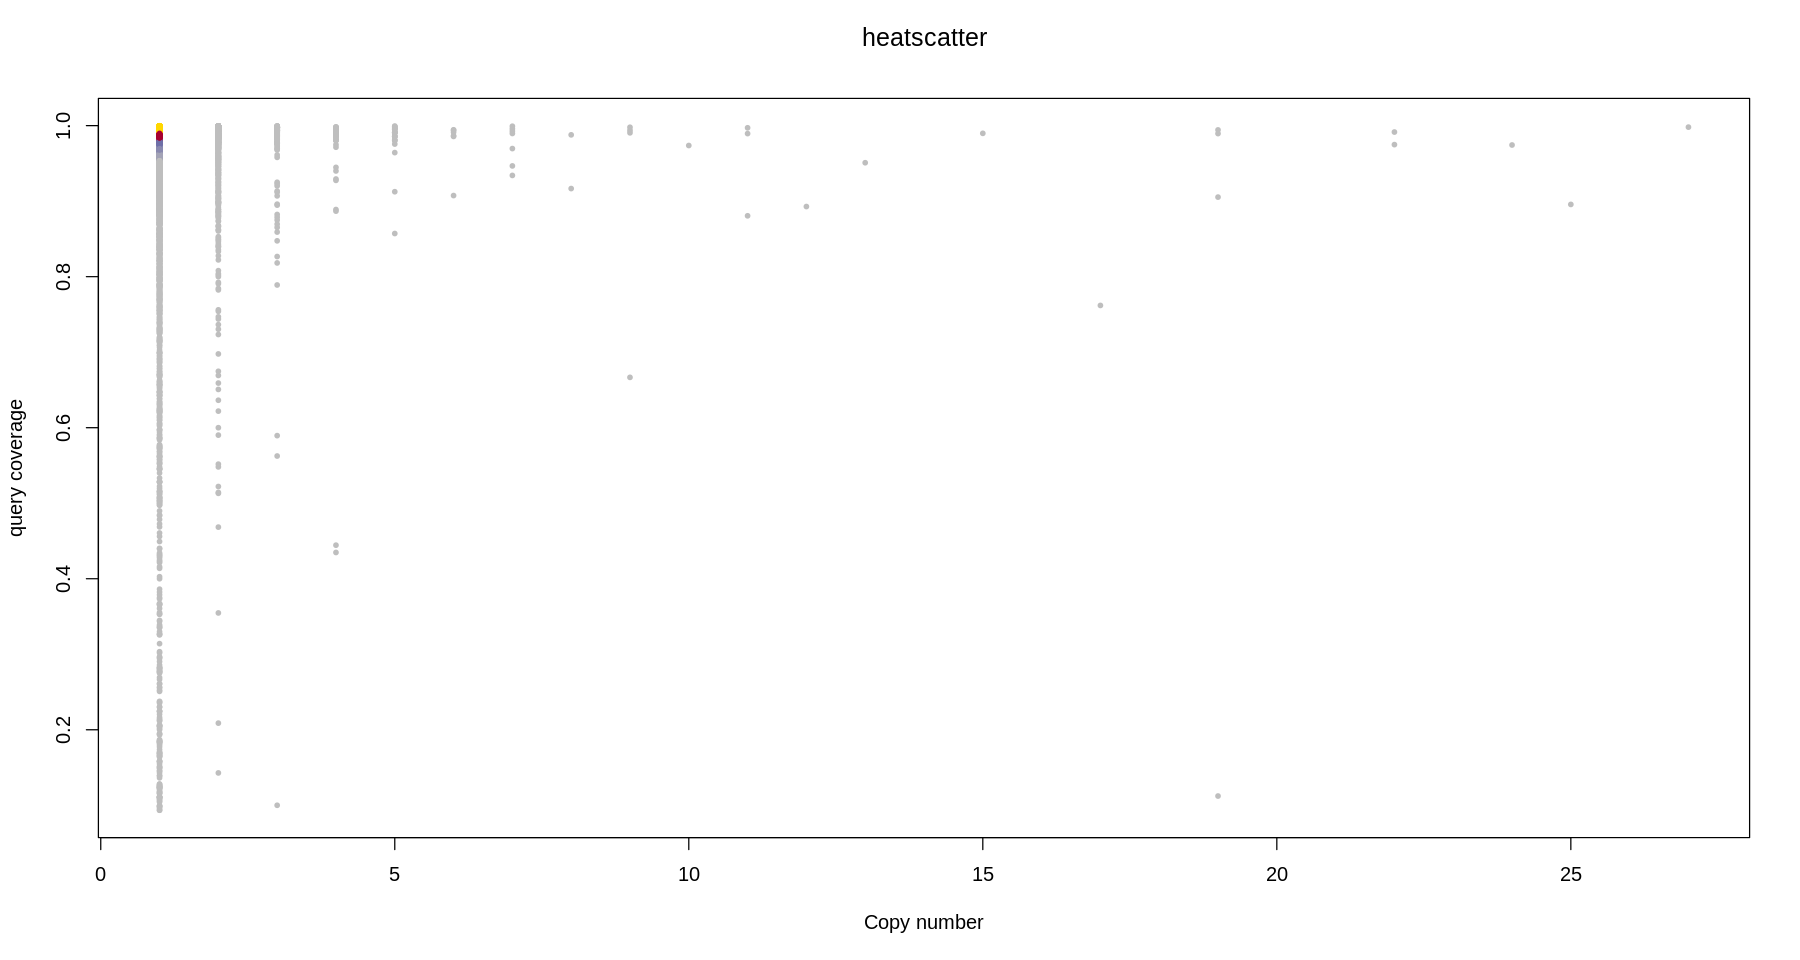

In [69]:
LSD::heatscatter(numContig[,800],cov_perOG[,800],xlab = "Copy number",ylab = "query coverage")

In [65]:
length(as.vector(numContig))

[1] 16047234

In [82]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7833548,418.4,22421586,1197.5,54740197,2923.5
Vcells,109450271,835.1,6019029116,45921.6,6311967135,48156.5


In [101]:
gff_original = readGFF(paste0("/workdir/sh2246/p_phyloGWAS/output/orthofinderMiniProt/ASM1935983v1.gff"))

if(nrow(gff_original)>0) {
    gff.mrna_original = gff_original[gff_original[,3]=="CDS",]

    queryStat_original = strsplit2(gff.mrna_original$Target," ")
    queryStat_original = as.data.frame(queryStat_original)
    colnames(queryStat_original) = c("query","start","end")
    queryStat_original$range = as.numeric(queryStat_original[,3])-as.numeric(queryStat_original[,2])+1
}


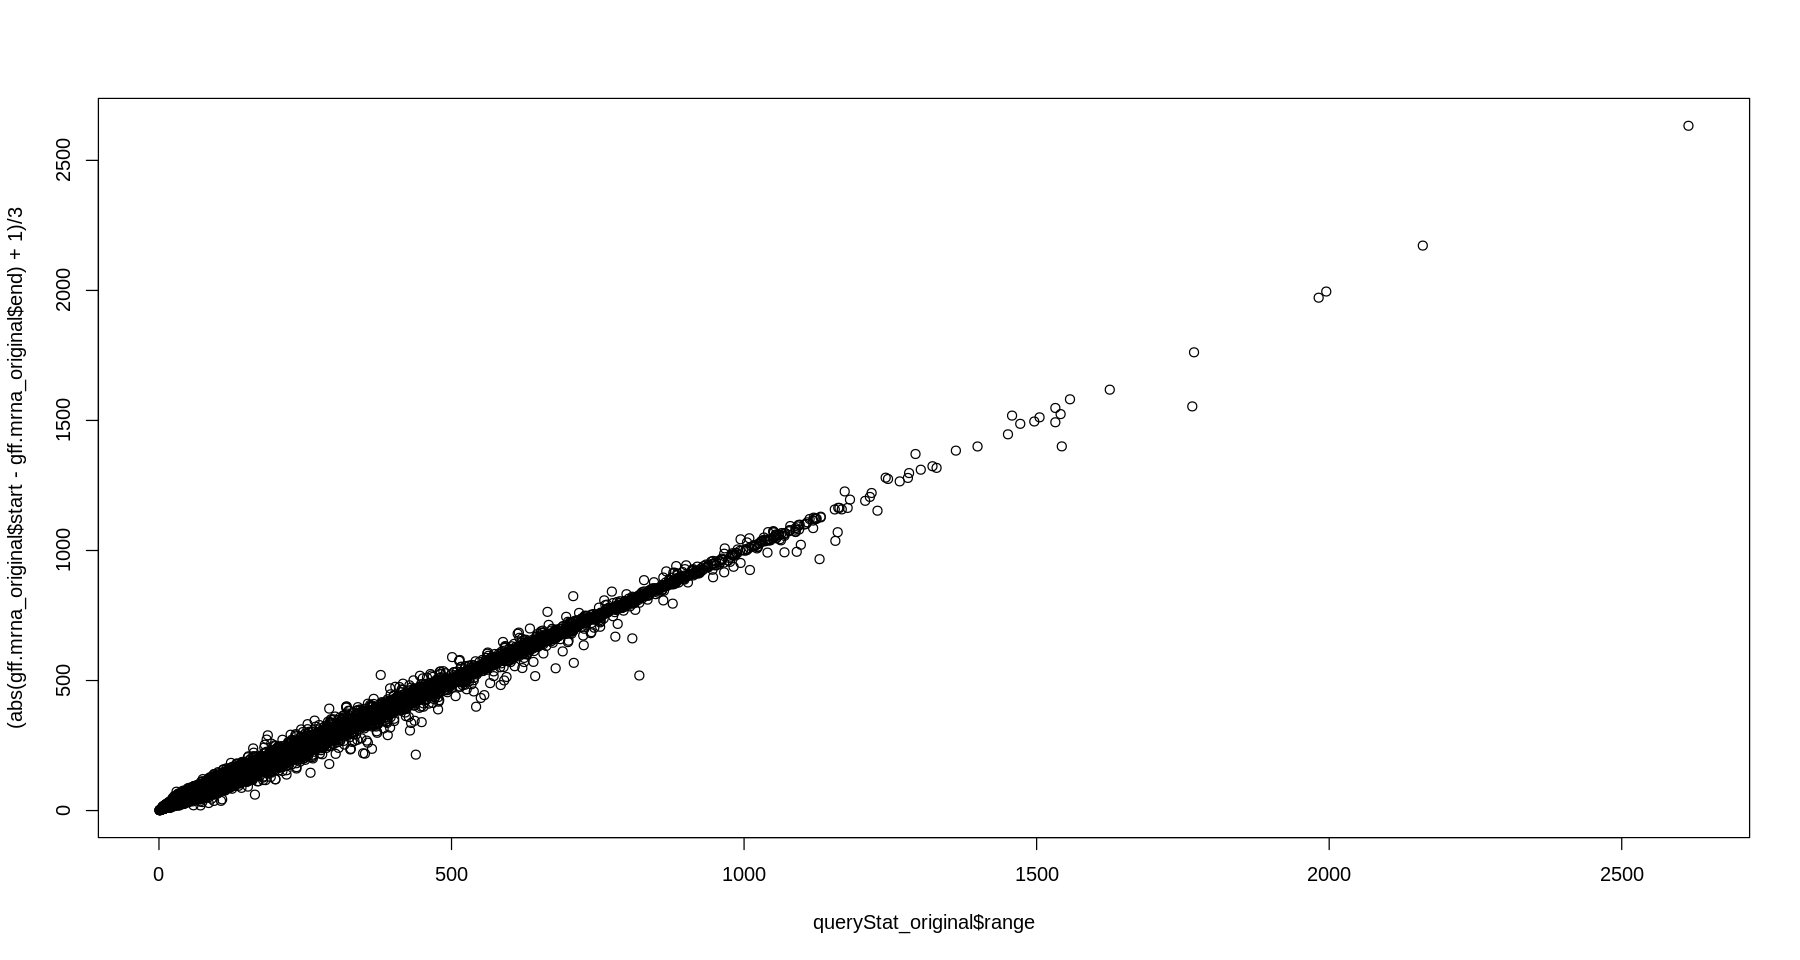

In [102]:
plot(queryStat_original$range,(abs(gff.mrna_original$start-gff.mrna_original$end)+1)/3)

In [128]:
table(tapply(queryStat_original$range*3-(abs(gff.mrna_original$start-gff.mrna_original$end)+1),as.character(gff.mrna_original$Parent),sum)%%3==0)


FALSE  TRUE 
  625 19014 

In [135]:
badMPID = unique(as.character(gff.mrna_original$Parent))[which(!tapply(queryStat_original$range*3-(abs(gff.mrna_original$start-gff.mrna_original$end)+1),as.character(gff.mrna_original$Parent),sum)%%3==0)]

In [139]:
badOGID = strsplit2(gff_original[as.character(gff_original$type) == "mRNA"&as.character(gff_original$ID)%in%badMPID,]$Target," ")[,1]

In [140]:
badOGID
length(unique(badOGID))

[1] "OG0001008" "OG0001024" "OG0001147" "OG0001229" "OG0001398" "OG0001778"
  [7] "OG0001961" "OG0001970" "OG0002130" "OG0002221" "OG0002428" "OG0002453"
 [13] "OG0002459" "OG0002467" "OG0002572" "OG0002591" "OG0002739" "OG0002739"
 [19] "OG0002754" "OG0002923" "OG0002955" "OG0003052" "OG0003068" "OG0003078"
 [25] "OG0003196" "OG0003215" "OG0003247" "OG0003399" "OG0003414" "OG0003456"
 [31] "OG0003491" "OG0003543" "OG0003567" "OG0003602" "OG0003834" "OG0003835"
 [37] "OG0003954" "OG0003962" "OG0004039" "OG0004040" "OG0004181" "OG0004222"
 [43] "OG0004230" "OG0004450" "OG0004472" "OG0004474" "OG0004524" "OG0004595"
 [49] "OG0004708" "OG0004851" "OG0004857" "OG0004861" "OG0004898" "OG0004909"
 [55] "OG0004965" "OG0005019" "OG0005062" "OG0005085" "OG0005101" "OG0005114"
 [61] "OG0005122" "OG0005126" "OG0005148" "OG0005178" "OG0005199" "OG0005225"
 [67] "OG0005265" "OG0005292" "OG0005294" "OG0005393" "OG0005399" "OG0005409"
 [73] "OG0005426" "OG0005494" "OG0005519" "OG0005524" "OG0005601" "OG0005629"
 [79] "OG0005638" "OG0005649" "OG0005753" "OG0005760" "OG0005788" "OG0005814"
 [85] "OG0005818" "OG0005823" "OG0005876" "OG0005886" "OG0005965" "OG0005999"
 [91] "OG0006037" "OG0006079" "OG0006198" "OG0006200" "OG0006204" "OG0006224"
 [97] "OG0006303" "OG0006323" "OG0006356" "OG0006450" "OG0006489" "OG0006530"
[103] "OG0006557" "OG0006592" "OG0006606" "OG0006784" "OG0006860" "OG0006865"
[109] "OG0006943" "OG0007055" "OG0007056" "OG0007076" "OG0007083" "OG0007098"
[115] "OG0007119" "OG0007124" "OG0007167" "OG0007176" "OG0007281" "OG0007284"
[121] "OG0007285" "OG0007378" "OG0007379" "OG0007517" "OG0007573" "OG0007633"
[127] "OG0007640" "OG0007646" "OG0007686" "OG0007705" "OG0007757" "OG0007790"
[133] "OG0007811" "OG0007884" "OG0007905" "OG0007923" "OG0007954" "OG0007992"
[139] "OG0008023" "OG0008027" "OG0008032" "OG0008040" "OG0008093" "OG0008197"
[145] "OG0008214" "OG0008230" "OG0008291" "OG0008291" "OG0008309" "OG0008338"
[151] "OG0008339" "OG0008480" "OG0008539" "OG0008564" "OG0008711" "OG0008779"
[157] "OG0008824" "OG0008831" "OG0008888" "OG0008928" "OG0009002" "OG0009044"
[163] "OG0009111" "OG0009129" "OG0009239" "OG0009264" "OG0009376" "OG0009394"
[169] "OG0009426" "OG0009442" "OG0009536" "OG0009573" "OG0009626" "OG0009709"
[175] "OG0009740" "OG0009744" "OG0009874" "OG0009954" "OG0009960" "OG0009977"
[181] "OG0009978" "OG0010000" "OG0010000" "OG0010001" "OG0010022" "OG0010023"
[187] "OG0010025" "OG0010051" "OG0010118" "OG0010160" "OG0010191" "OG0010213"
[193] "OG0010217" "OG0010218" "OG0010266" "OG0010293" "OG0010301" "OG0010303"
[199] "OG0010384" "OG0010480" "OG0010503" "OG0010549" "OG0010618" "OG0010677"
[205] "OG0010703" "OG0010740" "OG0010763" "OG0010773" "OG0010795" "OG0010954"
[211] "OG0010988" "OG0011027" "OG0011030" "OG0011084" "OG0011114" "OG0011118"
[217] "OG0011133" "OG0011144" "OG0011153" "OG0011224" "OG0011233" "OG0011271"
[223] "OG0011289" "OG0011324" "OG0011359" "OG0011450" "OG0011497" "OG0011560"
[229] "OG0011596" "OG0011609" "OG0011680" "OG0011719" "OG0011746" "OG0011766"
[235] "OG0011857" "OG0011908" "OG0011922" "OG0011963" "OG0011968" "OG0012015"
[241] "OG0012113" "OG0012138" "OG0012139" "OG0012186" "OG0012255" "OG0012293"
[247] "OG0012342" "OG0012346" "OG0012347" "OG0012375" "OG0012389" "OG0012392"
[253] "OG0012438" "OG0012445" "OG0012465" "OG0012473" "OG0012486" "OG0012514"
[259] "OG0012555" "OG0012615" "OG0012680" "OG0012738" "OG0012808" "OG0012816"
[265] "OG0012846" "OG0012940" "OG0012974" "OG0012986" "OG0013050" "OG0013130"
[271] "OG0013153" "OG0013276" "OG0013278" "OG0013326" "OG0013447" "OG0013496"
[277] "OG0013514" "OG0013518" "OG0013591" "OG0013620" "OG0013744" "OG0013808"
[283] "OG0013869" "OG0013901" "OG0013948" "OG0013970" "OG0014033" "OG0014042"
[289] "OG0014049" "OG0014079" "OG0014157" "OG0014273" "OG0014277" "OG0014282"
[295] "OG0014286" "OG0014305" "OG0014313" "OG0014405" "OG0014439" "OG0014564"
[301] "OG0014589" "OG0014640" "OG0014643" "OG0014705" "OG0014750" "OG0014833"
[307] "OG0014847" "OG001

[1] 614

In [141]:
missingOG = read.table("/workdir/sh2246/p_phyloGWAS/output/missingOGs.txt")[,1]

In [144]:
missingOG = gsub('_mafft.fa','',missingOG)

In [148]:
length(intersect(missingOG,unique(badOGID)))

[1] 587

In [170]:
sort(setdiff(missingOG,unique(badOGID)))
length(sort(setdiff(missingOG,unique(badOGID))))
setdiff(unique(badOGID),missingOG)
length(setdiff(unique(badOGID),missingOG))

[1] "OG0003576" "OG0004281" "OG0004969" "OG0005032" "OG0005110" "OG0006168"
  [7] "OG0006244" "OG0006321" "OG0006328" "OG0006968" "OG0007752" "OG0007962"
 [13] "OG0008191" "OG0008224" "OG0008413" "OG0009001" "OG0009409" "OG0009696"
 [19] "OG0009850" "OG0009971" "OG0010442" "OG0010793" "OG0011932" "OG0012372"
 [25] "OG0012638" "OG0012772" "OG0013184" "OG0013303" "OG0013312" "OG0013528"
 [31] "OG0014597" "OG0015534" "OG0015760" "OG0016058" "OG0017317" "OG0017420"
 [37] "OG0017461" "OG0017586" "OG0017743" "OG0018514" "OG0018636" "OG0018648"
 [43] "OG0018784" "OG0018874" "OG0019178" "OG0019182" "OG0019309" "OG0019333"
 [49] "OG0019383" "OG0019388" "OG0019495" "OG0019550" "OG0019618" "OG0019622"
 [55] "OG0019649" "OG0019911" "OG0019912" "OG0019945" "OG0020091" "OG0020115"
 [61] "OG0020203" "OG0020222" "OG0020516" "OG0020522" "OG0020538" "OG0020614"
 [67] "OG0020615" "OG0020642" "OG0020838" "OG0020908" "OG0020950" "OG0020967"
 [73] "OG0021198" "OG0021199" "OG0021260" "OG0021262" "OG0021362" "OG0021377"
 [79] "OG0021409" "OG0021535" "OG0021567" "OG0021593" "OG0021913" "OG0021975"
 [85] "OG0022142" "OG0022157" "OG0022163" "OG0022165" "OG0022443" "OG0022447"
 [91] "OG0022657" "OG0022749" "OG0022759" "OG0022845" "OG0022878" "OG0022915"
 [97] "OG0022985" "OG0023026" "OG0023037" "OG0023218" "OG0023350" "OG0023377"
[103] "OG0023451" "OG0023698" "OG0023732" "OG0023806" "OG0023906" "OG0024010"
[109] "OG0024135" "OG0024201" "OG0024498" "OG0024637" "OG0024655" "OG0024673"
[115] "OG0024677" "OG0024793" "OG0025185" "OG0025207" "OG0025351" "OG0025483"
[121] "OG0025600" "OG0025873" "OG0026178" "OG0026179" "OG0026648" "OG0026688"
[127] "OG0027493" "OG0027597" "OG0027604" "OG0028524" "OG0028670" "OG0028682"
[133] "OG0028730" "OG0029261" "OG0029827" "OG0029955" "OG0030426" "OG0030694"

[1] 138

[1] "OG0002923" "OG0003399" "OG0005101" "OG0005122" "OG0005876" "OG0006079"
 [7] "OG0006450" "OG0007284" "OG0007379" "OG0007757" "OG0007811" "OG0007992"
[13] "OG0008023" "OG0010000" "OG0010023" "OG0012465" "OG0015058" "OG0016453"
[19] "OG0016634" "OG0017895" "OG0020196" "OG0020397" "OG0020509" "OG0020618"
[25] "OG0021183" "OG0023096" "OG0025331"

[1] 27

In [168]:
write.table(paste0(sort(setdiff(missingOG,unique(badOGID))),"_mafft.fa"),
            "/workdir/sh2246/p_phyloGWAS/output/testMissingOGs.txt",quote = F,col.names = F,row.names = F)

In [166]:
tapply((abs(gff.mrna_original$start-gff.mrna_original$end)+1),as.character(gff.mrna_original$Parent),sum)['MP001491']

MP001491 
    1995

In [160]:
gff.mrna_original[strsplit2(as.character(gff.mrna_original$Target)," ")[,1]%in%"OG0003399",]

DataFrame with 16 rows and 18 columns
         seqid   source     type     start       end     score      strand
      <factor> <factor> <factor> <integer> <integer> <numeric> <character>
1   CM033319.1 miniprot      CDS  86605383  86605538       109           +
2   CM033319.1 miniprot      CDS  86605635  86605728        74           +
3   CM033319.1 miniprot      CDS  86605847  86605902        65           +
4   CM033319.1 miniprot      CDS  86605990  86606520       422           +
5   CM033319.1 miniprot      CDS  86606914  86607468       747           +
...        ...      ...      ...       ...       ...       ...         ...
12  CM033321.1 miniprot      CDS  90541104  90541578       402           -
13  CM033321.1 miniprot      CDS  90540215  90540790       773           -
14  CM033321.1 miniprot      CDS  90539899  90540111       360           -
15  CM033321.1 miniprot      CDS  90539537  90539683       215           -
16  CM033321.1 miniprot      CDS  90538880  90539116       141

In [99]:
sum(as.numeric(gff.mrna_original$Frameshift),na.rm = T)

[1] 1005

In [158]:
578-104+1

[1] 475